In [ ]:
# 주식 종목 불러오는 패키지
!pip install finance-datareader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 4.3 MB/s eta 0:00:00


In [ ]:
import FinanceDataReader as fdr

# 삼성전자

In [ ]:
# 삼성전자로 세팅됨, 종목번호 및 기간 바꿔서 진행
df = fdr.DataReader('005930', '2024-01-01', '2025-12-31')
df.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2025-07-17,65900,66800,64400,66700,39448683,0.030912
2025-07-18,67000,67800,66300,67100,23951531,0.005997
2025-07-21,67400,68800,67200,67800,17723148,0.010432
2025-07-22,68100,68500,65600,66000,20829006,-0.026549
2025-07-23,66200,66500,64900,66300,13244105,0.004545


# 분석 코드

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# GPU 꼭 연결해서 사용하세요~!
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

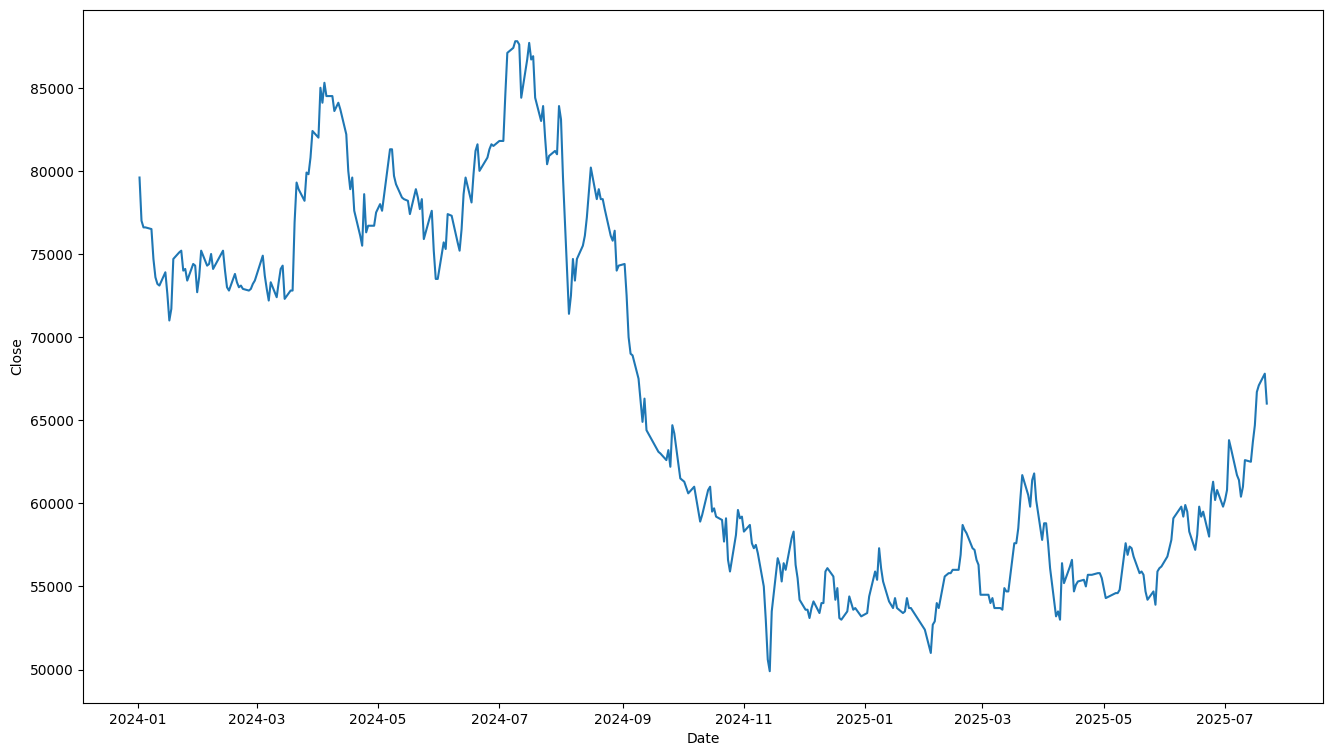

In [ ]:
plt.figure(figsize=(16, 9))
sns.lineplot(x=df.index, y='Close', data=df) # 종가를 plot
plt.show()

# 데이터 전처리

In [ ]:
#종가 제외 스케일링 (반응변수 = 종가)
scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Volume']] = scaler.fit_transform(df[['Open','High', 'Low','Volume']])

In [ ]:
#넘파이 배열로 변경
x = df[['Open', 'High', 'Low', 'Volume']].values
y = df['Close'].values

#시퀀스 데이터 생성
def seq_data(x, y, sequence_length): # sequence_length = 5라면, 과거 시점 5개의 데이터 시퀀스를 보고 다음값 예측
  x_seq = []
  y_seq = []
  for i in range(len(x) - sequence_length):
    x_seq.append(x[ i : i + sequence_length]) # sequence_length개(인덱스 i부터 인덱 i + sequence_length - 1)의 과거 'Open', 'High', 'Low', 'Volume' 데이터를 x에 추가
    y_seq.append(y[i + sequence_length]) # 과거 데이터 시퀀스 바로 다음 값이 예측에 대한 정답값이므로 y에 추가

  #gpu용 텐서로 변환
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1) # view(-1, 1): y_seq를 2차원 텐서로 변환

In [ ]:
split = 200
sequence_length=5 # 5일치씩 묶기
x_seq, y_seq = seq_data(x, y, sequence_length)

#순서대로 70개는 학습, 나머지는 평가 -> 200개 학습?
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]

x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([200, 5, 4]) torch.Size([200, 1])
torch.Size([174, 5, 4]) torch.Size([174, 1])


In [ ]:
x_train_seq

tensor([[[0.7311, 0.7594, 0.7608, 0.2179],
         [0.7389, 0.7326, 0.7285, 0.3068],
         [0.6762, 0.6925, 0.7043, 0.1828],
         [0.6919, 0.6872, 0.7124, 0.1052],
         [0.6997, 0.6979, 0.7124, 0.1011]],

        [[0.7389, 0.7326, 0.7285, 0.3068],
         [0.6762, 0.6925, 0.7043, 0.1828],
         [0.6919, 0.6872, 0.7124, 0.1052],
         [0.6997, 0.6979, 0.7124, 0.1011],
         [0.7102, 0.7032, 0.6559, 0.3891]],

        [[0.6762, 0.6925, 0.7043, 0.1828],
         [0.6919, 0.6872, 0.7124, 0.1052],
         [0.6997, 0.6979, 0.7124, 0.1011],
         [0.7102, 0.7032, 0.6559, 0.3891],
         [0.6475, 0.6364, 0.6263, 0.2780]],

        ...,

        [[0.2089, 0.1898, 0.1801, 0.4948],
         [0.1514, 0.1471, 0.1586, 0.3854],
         [0.1436, 0.1898, 0.1559, 0.4229],
         [0.2037, 0.2193, 0.1989, 0.4344],
         [0.2324, 0.2246, 0.2339, 0.2699]],

        [[0.1514, 0.1471, 0.1586, 0.3854],
         [0.1436, 0.1898, 0.1559, 0.4229],
         [0.2037, 0.2193, 0.1989

In [ ]:
# TensorDataset은 입력 데이터(x)와 정답(y)을 쌍으로 묶어서 관리하는 클래스
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 5
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size = batch_size)

# Vanila RNN
## 모델 구축

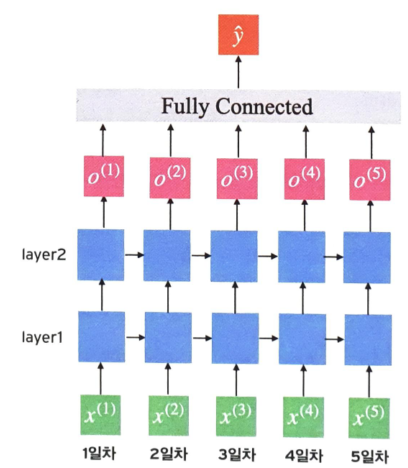

In [ ]:
#기본 하이퍼 파라미터 설정
input_size = x_seq.size(2) # input_size = 4 (피처의 개수)
num_layers = 2
hidden_size = 8

In [ ]:
class VanillaRNN(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(VanillaRNN, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) # 한 줄로 모델 정의(batch_first=True: 입력을 (배치 크기, sequence_length, input_size)로 받겠다는 뜻)
    self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 1), nn.Sigmoid()) # RNN 층에서 나온 결과를 fc 층으로 전달해서 예측값 계산(시퀀스의 모든 시점의 은닉 상태들을 flatten)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) # 초기 은닉 상태를 초기값 0으로 설정 / x.size()[0]: 배치 크
    out,_ = self.rnn(x, h0) # RNN 층에 입력 x와 초기 은닉 상태 h0를 넣어 은닉 상태 시퀀스를 구함 -> out: 모든 시점의 은닉 상태 / _: 최종 은닉 상태
    out = out.reshape(out.shape[0], -1) # out을 fc층에 넣기 위해 Flatten
    out = self.fc(out) # Flatten된 벡터를 받아서 최종 예측
    return out

In [ ]:
model = VanillaRNN(input_size=input_size,
                   hidden_size = hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device=device).to(device)

In [ ]:
criterion = nn.MSELoss()
num_epochs = 50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## 모델 학습

In [ ]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
  running_loss = 0

  for data in train_loader:
    seq, target = data #배치 데이터
    out = model(seq) #출력값 계산
    loss = criterion(out, target) #손실함수 계산

    optimizer.zero_grad()
    loss.backward()
    optimizer.step() #최적화
    running_loss += loss.item()

  loss_graph.append(running_loss/n) # 한 epoch 동안의 평균 손실값
  if epoch % 10 ==0:
    print('[epoch : %d] loss: %.4f' %(epoch, running_loss/n))

[epoch : 0] loss: 5645676620.8000
[epoch : 10] loss: 5645620473.6000
[epoch : 20] loss: 5645620339.2000
[epoch : 30] loss: 5645620473.6000
[epoch : 40] loss: 5645620390.4000


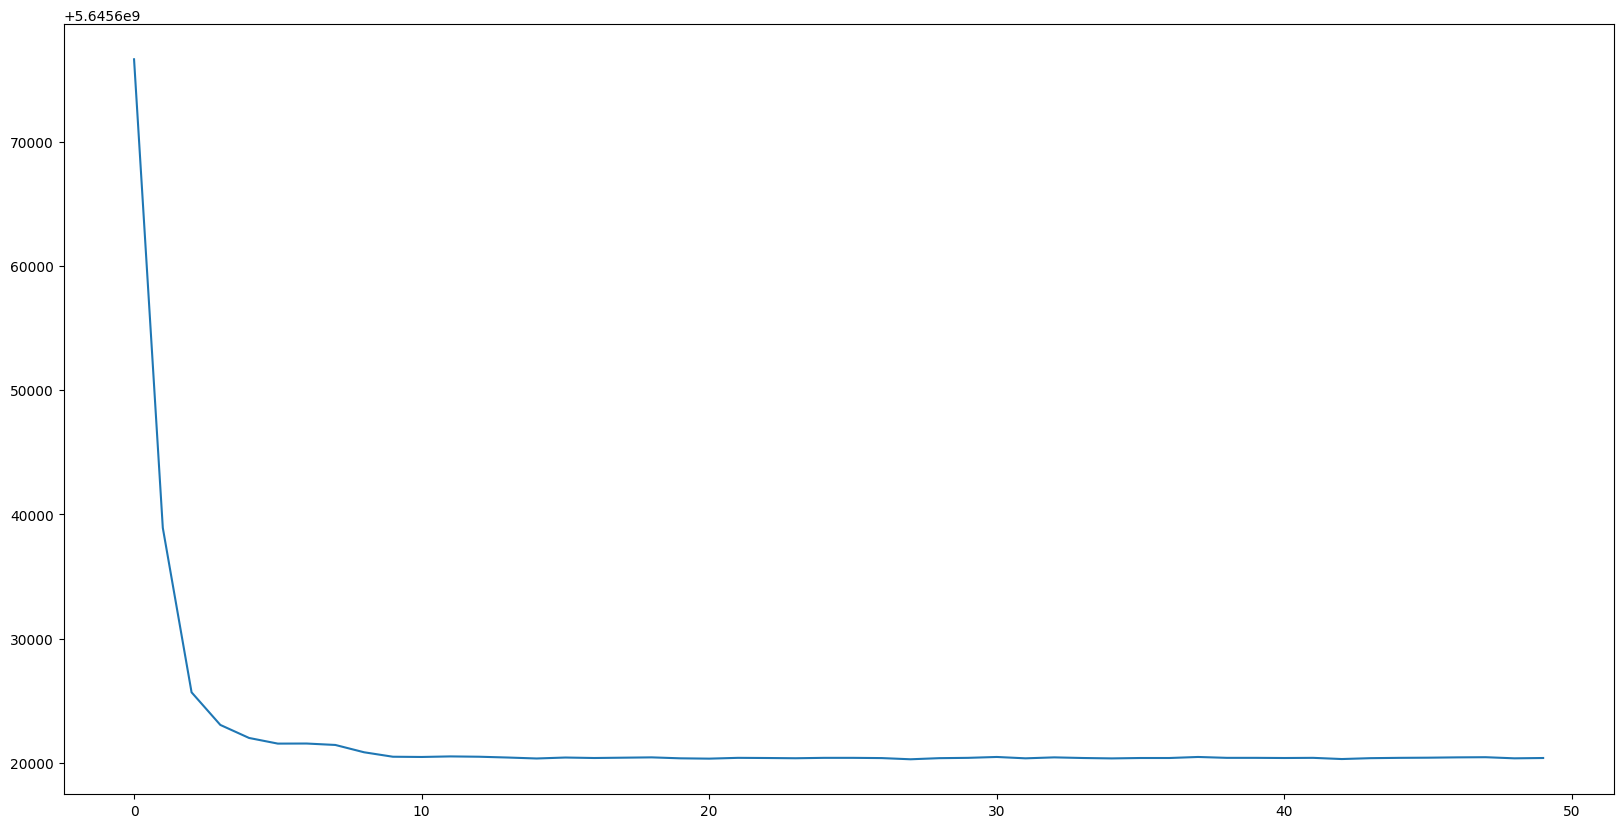

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

## loss가 너무 크게 나와서... 종가도 스케일링 해보기 -> 해결됨!

In [ ]:
df = fdr.DataReader('005930', '2024-01-01', '2025-12-31')

scaler_x = MinMaxScaler()
df[['Open', 'High', 'Low', 'Volume']] = scaler_x.fit_transform(df[['Open','High', 'Low','Volume']])

scaler_y = MinMaxScaler()
df[['Close']] = scaler_y.fit_transform(df[['Close']])

#넘파이 배열로 변경
x = df[['Open', 'High', 'Low', 'Volume']].values
y = df['Close'].values

#시퀀스 데이터 생성
def seq_data(x, y, sequence_length): # sequence_length = 5라면, 과거 시점 5개의 데이터 시퀀스를 보고 다음값 예측
  x_seq = []
  y_seq = []
  for i in range(len(x) - sequence_length):
    x_seq.append(x[ i : i + sequence_length]) # sequence_length개(인덱스 i부터 인덱 i + sequence_length - 1)의 과거 'Open', 'High', 'Low', 'Volume' 데이터를 x에 추가
    y_seq.append(y[i + sequence_length]) # 과거 데이터 시퀀스 바로 다음 값이 예측에 대한 정답값이므로 y에 추가

  #gpu용 텐서로 변환
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1) # view(-1, 1): y_seq를 2차원 텐서로 변환

In [ ]:
split = 200
sequence_length=5 # 5일치씩 묶기
x_seq, y_seq = seq_data(x, y, sequence_length)

#순서대로 70개는 학습, 나머지는 평가 -> 200개 학습?
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]

x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([200, 5, 4]) torch.Size([200, 1])
torch.Size([174, 5, 4]) torch.Size([174, 1])


In [ ]:
# TensorDataset은 입력 데이터(x)와 정답(y)을 쌍으로 묶어서 관리하는 클래스
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 5
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size = batch_size)

In [ ]:
model = VanillaRNN(input_size=input_size,
                   hidden_size = hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device=device).to(device)

criterion = nn.MSELoss()
num_epochs = 50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
  running_loss = 0

  for data in train_loader:
    seq, target = data #배치 데이터
    out = model(seq) #출력값 계산
    loss = criterion(out, target) #손실함수 계산

    optimizer.zero_grad()
    loss.backward()
    optimizer.step() #최적화
    running_loss += loss.item()

  loss_graph.append(running_loss/n) # 한 epoch 동안의 평균 손실값
  if epoch % 10 ==0:
    print('[epoch : %d] loss: %.4f' %(epoch, running_loss/n))

[epoch : 0] loss: 0.0423
[epoch : 10] loss: 0.0062
[epoch : 20] loss: 0.0043
[epoch : 30] loss: 0.0039
[epoch : 40] loss: 0.0035


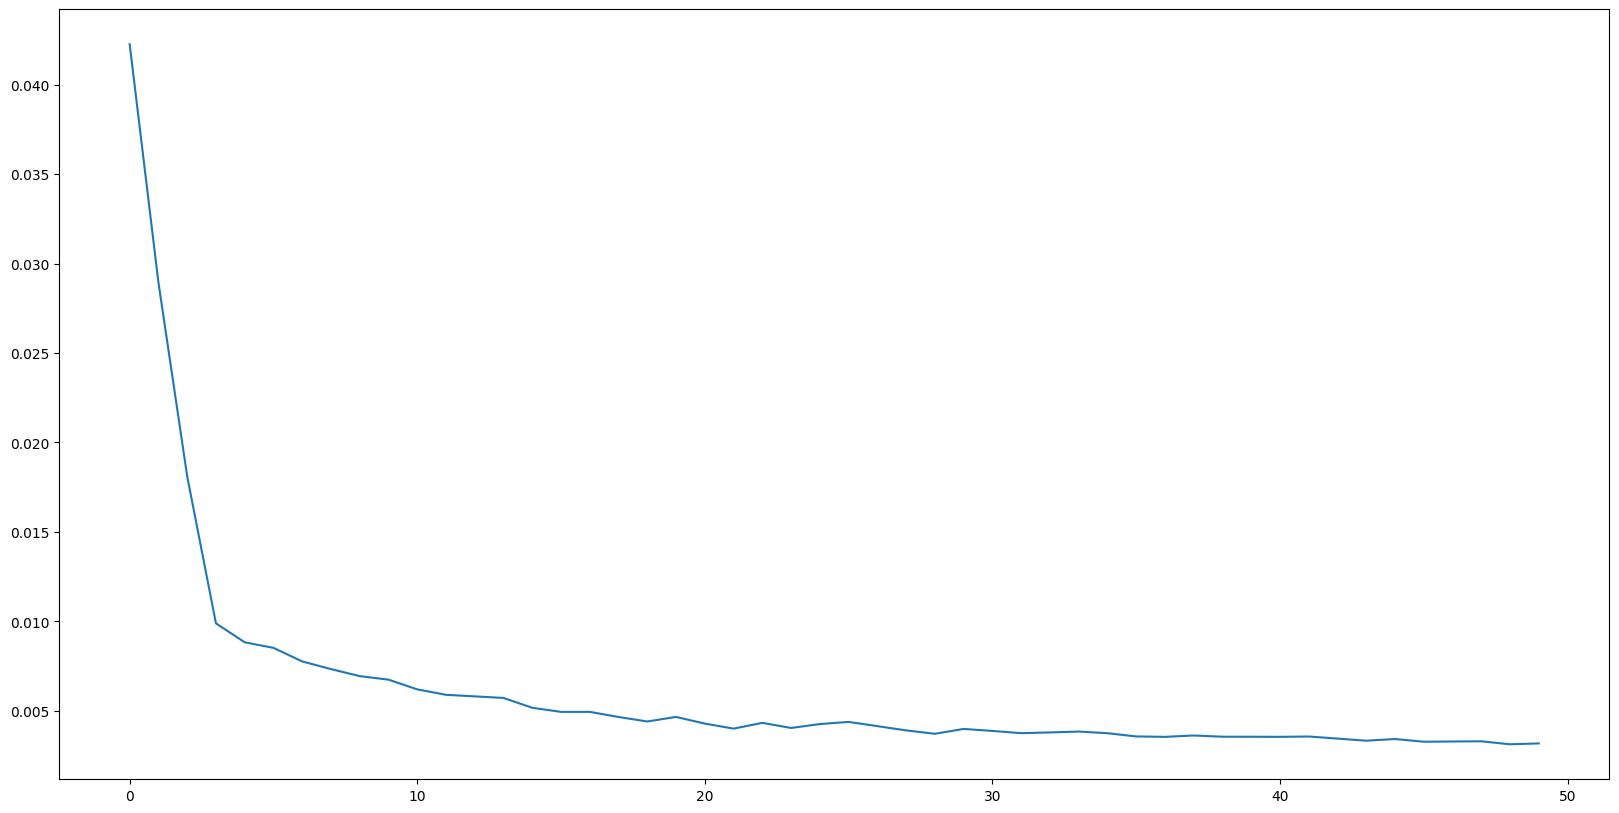

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

## 실제값과 예측값 비교

In [ ]:
concatdata = torch.utils.data.ConcatDataset([train, test]) # train과 test TensorDateset을 하나로 합침
data_loader = torch.utils.data.DataLoader(dataset = concatdata, batch_size = 100)

with torch.no_grad(): # torch.no_grad(): 역전파에 필요한 기울기 계산을 하지 않음(예측을 할 때는 불필요하기 때문)
  pred = []
  model.eval() # 모델을 평가 모드로 전환 -> 학습 시에만 쓰이는 기능들 비활성화
  for data in data_loader:
    seq, target = data
    out = model(seq)
    pred += out.cpu().tolist() # GPU에 있던 예측값인 out을 CPU로 옮김(출력값을 파이썬에서 다루려면 CPU 메모리에 있어야 함) -> 리스트로 변환

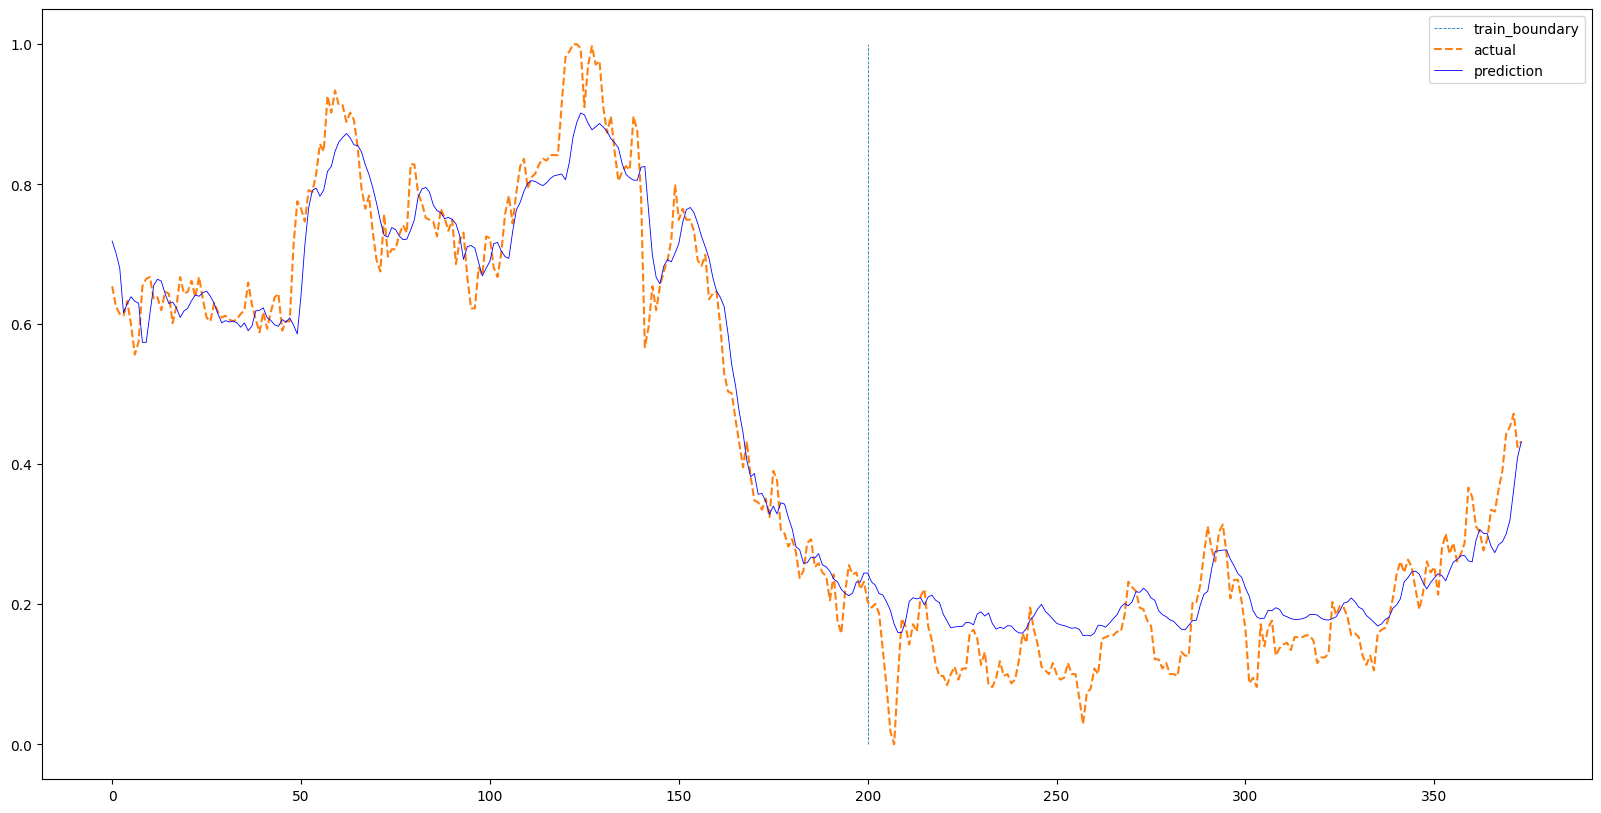

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(np.ones(100)*len(train), np.linspace(0,1,100), '--', linewidth=0.6) # train과 test data 구분 지점에 수직선
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred, 'b', linewidth = 0.6)
plt.legend(['train_boundary','actual','prediction'])
plt.show()

test data 구간으로 넘어가면 실제값과의 오차가 좀 더 벌어지는 듯

# LSTM
## 모델구축

In [ ]:
#하이퍼 파라미터 정의
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [ ]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(LSTM, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_size*sequence_length ,1)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) # 초기 은닉 상태 초기화
    # LSTM에는 셀 상태도 있음 -> RNN은 은닉 상태 하나로 모든 정보를 기억하지만, LSTM은 셀 상태라는 장기 기억 저장소를 둠
    # -> 기울기 소실 문제 완화 -> 장기 예측에도 강함
    c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) # 초기 셀 상태 초기화
    out, _ = self.lstm(x,(h0,c0))
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

In [ ]:
model = LSTM(input_size = input_size,
             hidden_size=hidden_size,
             sequence_length=sequence_length,
             num_layers = num_layers,
             device=device).to(device)

In [ ]:
criterion = nn.MSELoss()
num_epochs =50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0

    for data in train_loader:

        seq, target = data # 배치 데이터
        out = model(seq)
        loss = criterion(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_graph.append(running_loss/n)
    if epoch % 10 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))


[epoch: 0] loss: 0.5777
[epoch: 10] loss: 0.0045
[epoch: 20] loss: 0.0047
[epoch: 30] loss: 0.0041
[epoch: 40] loss: 0.0041


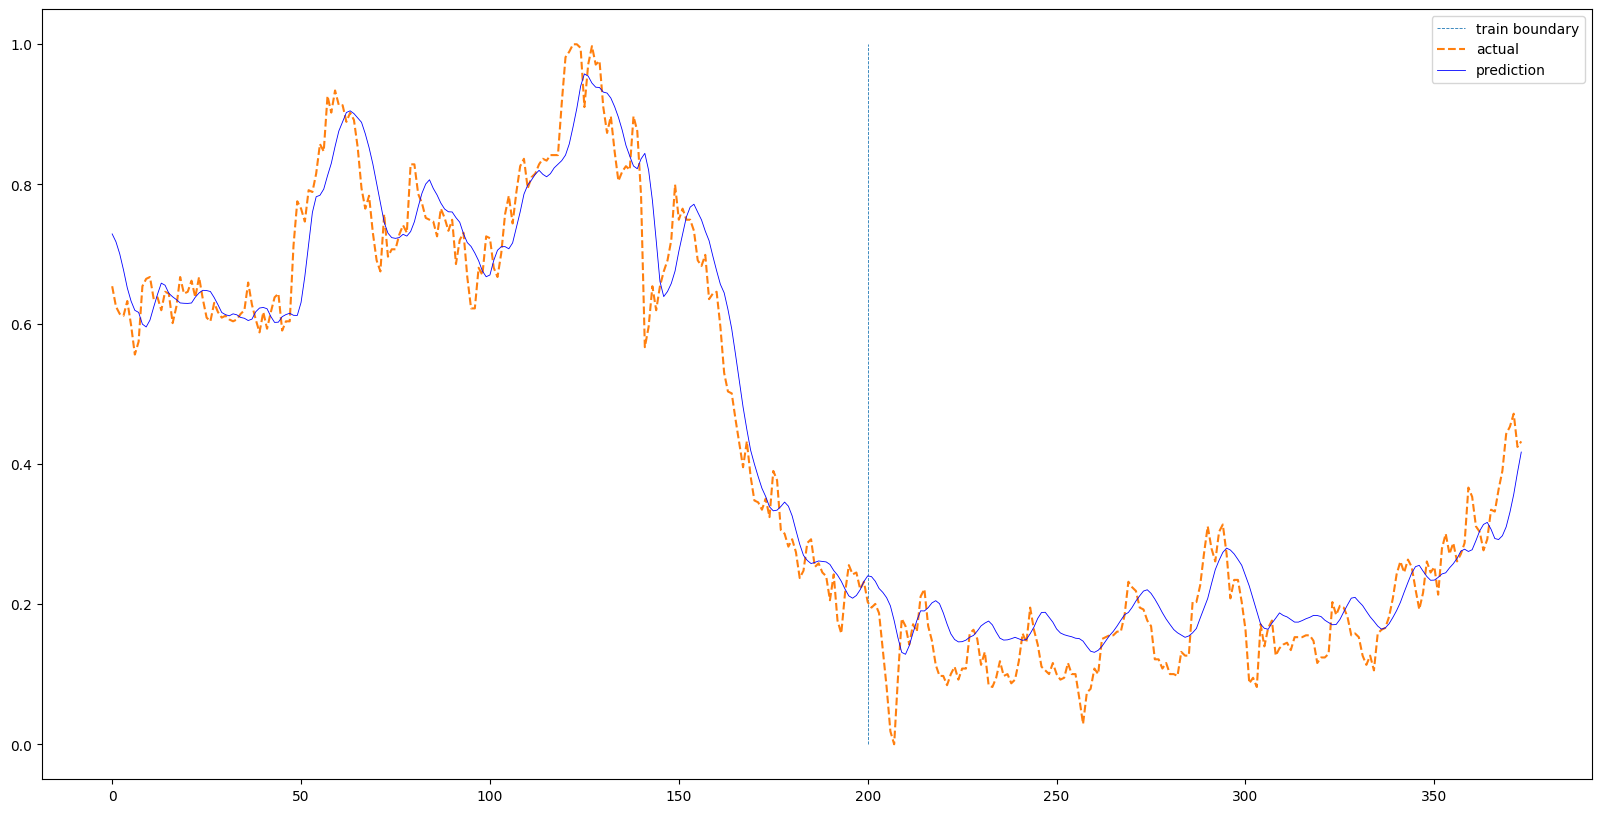

In [ ]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset=concatdata, batch_size=100, shuffle=False)

with torch.no_grad():
    pred = []
    model.eval()
    for data in data_loader:
        seq, target = data
        out = model(seq)
        pred += out.cpu().tolist()

plt.figure(figsize=(20,10))
plt.plot(np.ones(100)*len(train),np.linspace(0,1,100),'--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred,'b', linewidth=0.6)
plt.legend(['train boundary','actual','prediction'])
plt.show()

# (Optional)

현대 자동차 주가에 대한 정보에 같은 분석을 해봅시다. 다음 코드를 한 번 실행한 뒤, 분석 코드부터 다시 그대로 돌려보시기 보고 결과에 대해 자유롭게 해석해보시기 바랍니다.

In [ ]:
# 현대자동자 주가로 세팅됨, 종목번호 및 기간 바꿔서 진행
df = fdr.DataReader('005380', '2024-01-01', '2025-12-31')
df.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2025-07-17,208500,212000,205500,210000,611349,0.012048
2025-07-18,210000,212500,208500,210500,317353,0.002381
2025-07-21,209500,210500,208000,209000,460835,-0.007126
2025-07-22,209000,209500,204500,206500,441603,-0.011962
2025-07-23,213000,223000,213000,222000,2745037,0.075061


## 데이터 전처리

In [ ]:
# 스케일링
scaler_x = MinMaxScaler()
df[['Open', 'High', 'Low', 'Volume']] = scaler_x.fit_transform(df[['Open','High', 'Low','Volume']])

scaler_y = MinMaxScaler()
df[['Close']] = scaler_y.fit_transform(df[['Close']])

#넘파이 배열로 변경
x = df[['Open', 'High', 'Low', 'Volume']].values
y = df['Close'].values

#시퀀스 데이터 생성
def seq_data(x, y, sequence_length):
  x_seq = []
  y_seq = []
  for i in range(len(x) - sequence_length):
    x_seq.append(x[ i : i + sequence_length])
    y_seq.append(y[i + sequence_length])

  #gpu용 텐서로 변환
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)

In [ ]:
# train / test 데이터셋 분할
split = int(len(df) * 0.7) # 200개로 하드코딩하지 않고, 7:3으로 분할
sequence_length=5 # 5일치씩 묶기
x_seq, y_seq = seq_data(x, y, sequence_length)

#순서대로 70%는 학습, 나머지는 평가
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]

x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([265, 5, 4]) torch.Size([265, 1])
torch.Size([109, 5, 4]) torch.Size([109, 1])


In [ ]:
# 입력 데이터(x)와 정답(y)을 쌍으로 묶어서 관리 / 데이터 로더 설정
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 5
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size = batch_size)

## Vanila RNN

In [ ]:
#기본 하이퍼 파라미터 설정
input_size = x_seq.size(2) # input_size = 4 (피처의 개수)
num_layers = 2
hidden_size = 8

In [ ]:
# 모델 정의
model = VanillaRNN(input_size=input_size,
                   hidden_size = hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device=device).to(device)

criterion = nn.MSELoss()
num_epochs = 50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# 모델 학습
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
  running_loss = 0

  for data in train_loader:
    seq, target = data #배치 데이터
    out = model(seq) #출력값 계산
    loss = criterion(out, target) #손실함수 계산

    optimizer.zero_grad()
    loss.backward()
    optimizer.step() #최적화
    running_loss += loss.item()

  loss_graph.append(running_loss/n) # 한 epoch 동안의 평균 손실값
  if epoch % 10 ==0:
    print('[epoch : %d] loss: %.4f' %(epoch, running_loss/n))

[epoch : 0] loss: 0.0428
[epoch : 10] loss: 0.0059
[epoch : 20] loss: 0.0048
[epoch : 30] loss: 0.0041
[epoch : 40] loss: 0.0036


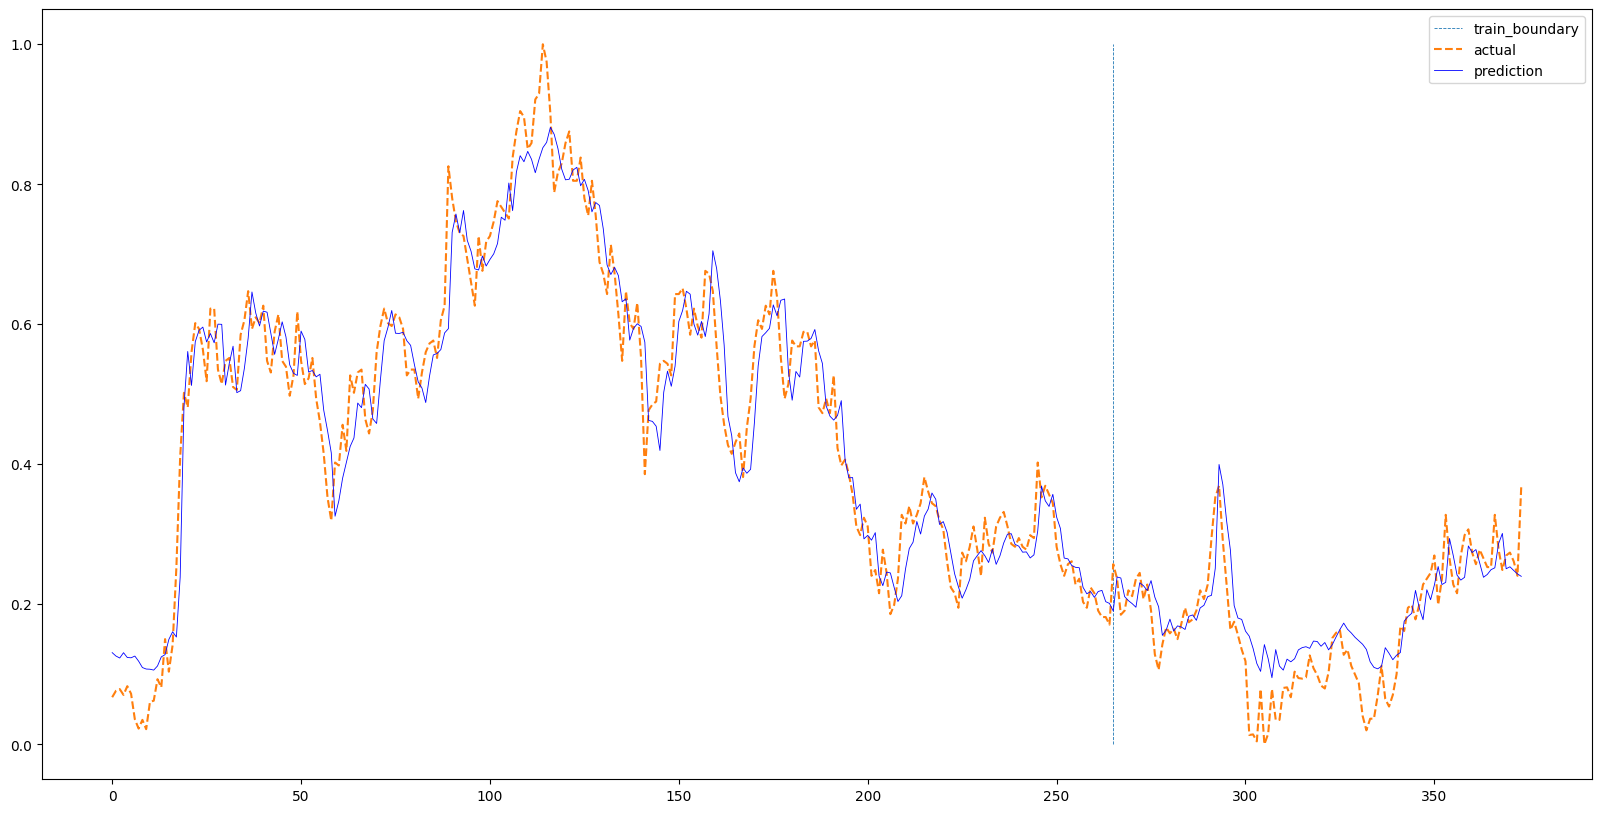

In [ ]:
# 예측값 생성
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset = concatdata, batch_size = 100)

with torch.no_grad():
  pred = []
  model.eval()
  for data in data_loader:
    seq, target = data
    out = model(seq)
    pred += out.cpu().tolist()

# 실제값과 예측값 비교 plot
plt.figure(figsize = (20,10))
plt.plot(np.ones(100)*len(train), np.linspace(0,1,100), '--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred, 'b', linewidth = 0.6)
plt.legend(['train_boundary','actual','prediction'])
plt.show()

## LSTM

In [ ]:
#하이퍼 파라미터 정의
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [ ]:
# 모델 정의
model = LSTM(input_size = input_size,
             hidden_size=hidden_size,
             sequence_length=sequence_length,
             num_layers = num_layers,
             device=device).to(device)

criterion = nn.MSELoss()
num_epochs = 50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# 모델 학습
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0

    for data in train_loader:

        seq, target = data # 배치 데이터
        out = model(seq)
        loss = criterion(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_graph.append(running_loss/n)
    if epoch % 10 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))

[epoch: 0] loss: 0.0769
[epoch: 10] loss: 0.0070
[epoch: 20] loss: 0.0060
[epoch: 30] loss: 0.0052
[epoch: 40] loss: 0.0043


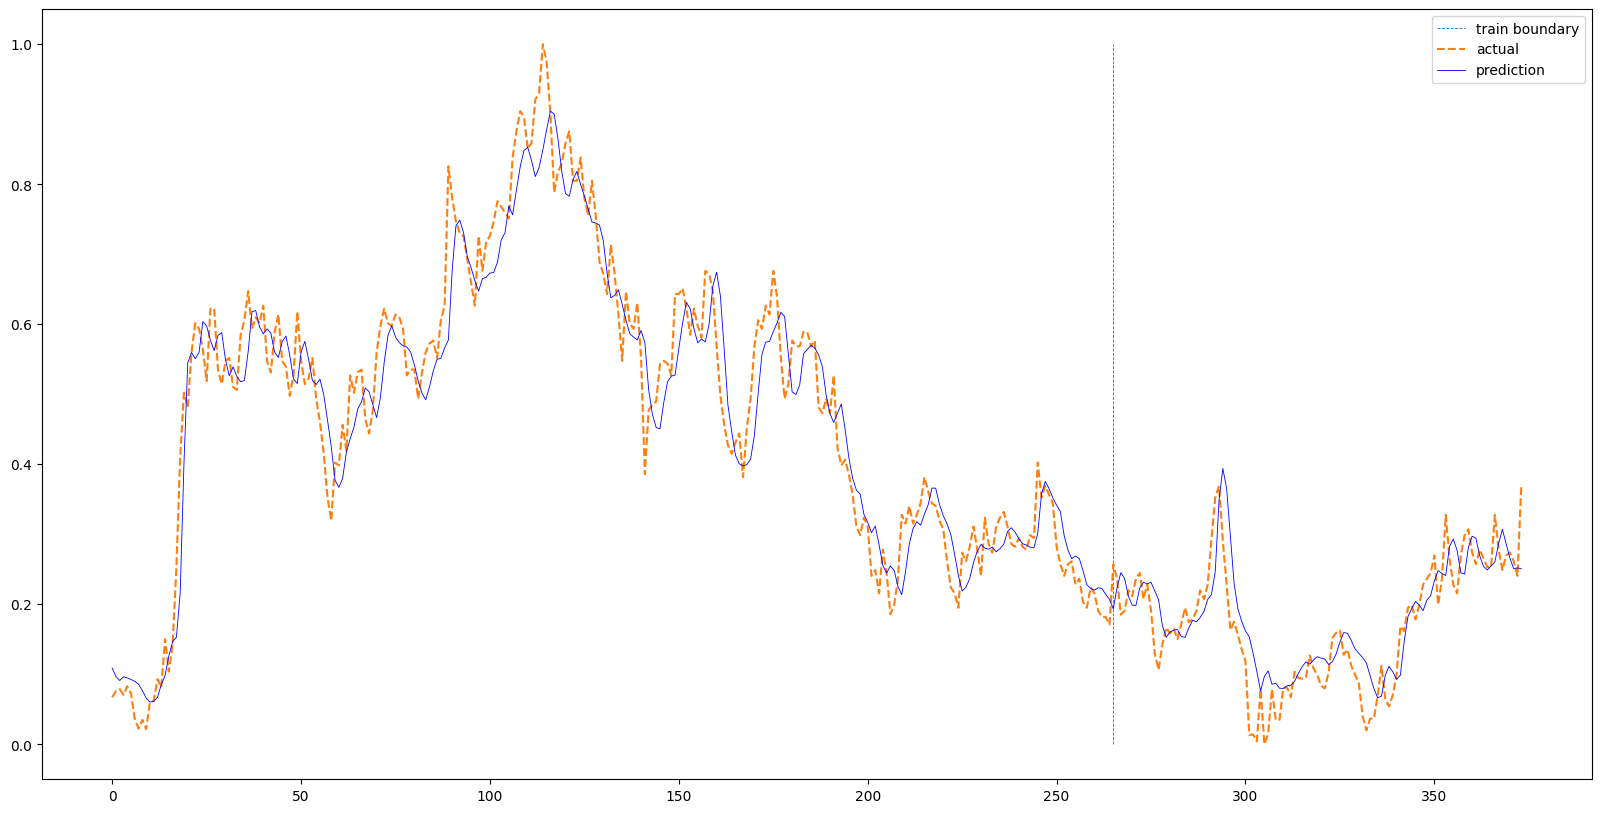

In [ ]:
# 예측값 생성
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset=concatdata, batch_size=100, shuffle=False)

with torch.no_grad():
    pred = []
    model.eval()
    for data in data_loader:
        seq, target = data
        out = model(seq)
        pred += out.cpu().tolist()

# 실제값과 예측값 비교 plot
plt.figure(figsize=(20,10))
plt.plot(np.ones(100)*len(train),np.linspace(0,1,100),'--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred,'b', linewidth=0.6)
plt.legend(['train boundary','actual','prediction'])
plt.show()

위에서와 마찬가지로 여기에서도 종가를 포함한 모든 변수를 스케일링 하였다.

그리고 train set을 200개로 고정하지 않고, 전체 데이터셋의 70%로 설정하였다. (7:3 분할) -> 이로 인해 train set으로 265개 정도가 활용되었다.

이렇게 train set으로 활용되는 비중을 늘렸더니, train set 구간에서의 loss 값은 유사하지만, test set 구간에서의 예측 정확도가 좀 더 높아진 것 같다. (plot 상으로 확인)

두 가지 데이터셋을 활용한 결과를 보니, LSTM은 RNN에 비해 학습 초기(epoch 0)에 loss가 크게 튄다는 점을 발견했다. 찾아보니, 이는 LSTM이 RNN보다 더 복잡한 내부 구조를 가지고 있고, 학습해야 할 파라미터 수도 많기 때문이라고 한다. 특히, 처음에는 랜덤으로 초기화된 파라미터의 수가 더 많고, 계산 흐름이 복잡해지다보니 학습 초기에는 불안정한 출력값을 낼 수 밖에 없는 것이다. 이후에는 학습이 진행되면서 loss가 바로 안정적으로 감소함을 확인하였다.